In [30]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src/')
import helpers as h
%matplotlib inline

## Useful constants

In [31]:
data_dir = "../simulations/"

In [32]:
n_samples = 100
x = np.arange(1, (n_samples+1)//2 + 1) / n_samples
sfs_neut = (1/x + 1/(1-x)) / n_samples
#pi_weight = 2*x*(1-x)
#print(x)
#print(pi_weight)

In [33]:
r_list = np.insert(np.logspace(-1,3,13), 0, 0.0)
print(r_list)

[  0.00000000e+00   1.00000000e-01   2.15443469e-01   4.64158883e-01
   1.00000000e+00   2.15443469e+00   4.64158883e+00   1.00000000e+01
   2.15443469e+01   4.64158883e+01   1.00000000e+02   2.15443469e+02
   4.64158883e+02   1.00000000e+03]


## Helper functions

In [34]:
def pmi(mSFS, jSFS):
    mSFS_sq = mSFS[:,None,:] * mSFS[:,:,None]
    return np.log2(jSFS / mSFS_sq)

In [35]:
def import_sfs(file_list, n_samples):
    n_files = len(file_list)
    mSFS = np.zeros((n_files, n_samples-1))
    jSFS_triu = np.zeros((n_files, n_samples*(n_samples-1)//2))
    
    # Import data from files
    for i, f in enumerate(file_list):
        with open(f) as datafile:
            for line in datafile:
                # Skip header lines
                if line.startswith('#'):
                    continue
                # First two non-header lines contain the marginal and joint SFS
                mSFS[i,:] = np.array(line.split(), dtype=float)
                jSFS_triu[i,:] = np.array(datafile.readline().split())
                break
                
    # Unpack the joint SFS
    jSFS = np.zeros((n_files, n_samples-1, n_samples-1))
    for i in range(n_files):
        jSFS[i,:,:][np.triu_indices(n_samples-1)] = jSFS_triu[i,:]
        # Don't double-count the diagonal values
        jSFS[i,:,:][np.diag_indices(n_samples-1)] /= 2
    # Symmetrize distribution
    jSFS += np.transpose(jSFS, axes=(0,2,1))
    
    # Fold marginal and joint SFS.
    mSFS_fold = (mSFS + mSFS[:,::-1])[:,:n_samples//2]
    jSFS_fold = (jSFS + jSFS[:,::-1,:] + jSFS[:,:,::-1] + jSFS[:,::-1,::-1])[:, :n_samples//2, :n_samples//2]
    # Don't double-count the n/2 = n - n/2 values.
    if n_samples % 2 == 0:
        mSFS_fold[:,-1] /= 2
        jSFS_fold[:,-1,:-1] /= 2
        jSFS_fold[:,:-1,-1] /= 2
        jSFS_fold[:,-1,-1] /= 4

    #pi = np.dot(mSFS_fold, pi_weight)
    pi = h.sfs2pi(mSFS_fold.T, n_samples)
    PMI = pmi(mSFS_fold, jSFS_fold)
    wPMI = PMI * jSFS_fold
    diag = np.sum(np.diagonal(wPMI, axis1=1, axis2=2), axis=1)
    offdiag = np.sum(wPMI, axis=(1,2)) - diag

    return pi, mSFS_fold, jSFS_fold, PMI, wPMI, diag, offdiag

# Import data

## Beta coalescents

In [36]:
a_list = [2.0, 1.75, 1.5, 1.25]

pi_beta = []
mSFS_beta = []
jSFS_beta = []
PMI_beta = []
wPMI_beta = []
diag_beta = []
offdiag_beta = []
for a in a_list:
    file_list = [data_dir + 'jsfs_a-{}_r-{}.txt'.format(a,r) for r in r_list[:-3]]
    results = import_sfs(file_list, n_samples)

    pi_beta.append(results[0])
    mSFS_beta.append(results[1])
    jSFS_beta.append(results[2])
    PMI_beta.append(results[3])
    wPMI_beta.append(results[4])
    diag_beta.append(results[5])
    offdiag_beta.append(results[6])

In [37]:
print(pi_beta[0].shape)
print(pi_beta[0])

(11,)
[ 1.99984105  1.99976596  1.9975245   2.00275723  2.00212653  2.0016864
  2.00095063  2.00158607  1.99895572  2.00272737  2.00252323]


## Exponential growth

In [38]:
g_list = [1.0, 2.0, 4.0, 8.0]

pi_exp = []
mSFS_exp = []
jSFS_exp = []
PMI_exp = []
wPMI_exp = []
diag_exp = []
offdiag_exp = []
for g in g_list:
    file_list = [data_dir + 'jsfs_g-{}_r-{}.txt'.format(g,r) for r in r_list[:-3]]
    results = import_sfs(file_list, n_samples)

    pi_exp.append(results[0])
    mSFS_exp.append(results[1])
    jSFS_exp.append(results[2])
    PMI_exp.append(results[3])
    wPMI_exp.append(results[4])
    diag_exp.append(results[5])
    offdiag_exp.append(results[6])

## Piecewise-constant growth

In [39]:
t_list = [0.01, 0.1, 1.0]
#s_list = [0.01, 0.05, 0.1]
s_list = [0.2, 0.1, 0.05, 0.01]
pi_pwc = []
mSFS_pwc = []
jSFS_pwc = []
PMI_pwc = []
wPMI_pwc = []
diag_pwc = []
offdiag_pwc = []
for t in t_list:
    for s in s_list:
        file_list = [data_dir + 'jsfs_T-{}_S-{}_r-{}.txt'.format(t,s,r) for r in r_list]
        #file_list = [data_dir + 'jsfs_T-{}_S-{}_r-{}.txt'.format(t,s,r) for r in r_list[:-3]]

        results = import_sfs(file_list, n_samples)

        pi_pwc.append(results[0])
        mSFS_pwc.append(results[1])
        jSFS_pwc.append(results[2])
        PMI_pwc.append(results[3])
        wPMI_pwc.append(results[4])
        diag_pwc.append(results[5])
        offdiag_pwc.append(results[6])

/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


# Marginal Site Frequency Spectra

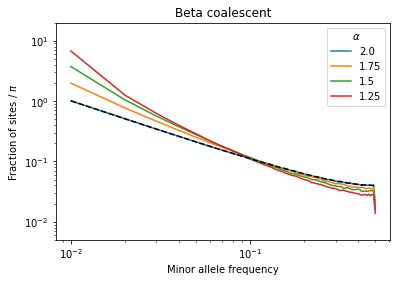

In [40]:
for i,a in enumerate(a_list):
    plt.loglog(x, mSFS_beta[i][0,:]/pi_beta[i][0], label=a)
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
plt.xlabel('Minor allele frequency')
plt.ylabel('Fraction of sites / $\pi$')
plt.legend(title=r'$\alpha$')
plt.title('Beta coalescent')

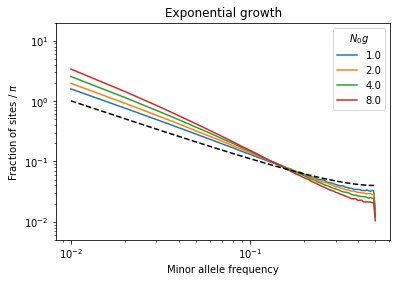

In [41]:
for i,g in enumerate(g_list):
    plt.loglog(x, mSFS_exp[i][0,:]/pi_exp[i][0], label=g)
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))


plt.xlabel('Minor allele frequency')
plt.ylabel('Fraction of sites / $\pi$')
plt.legend(title=r'$N_0g$')
plt.title('Exponential growth')

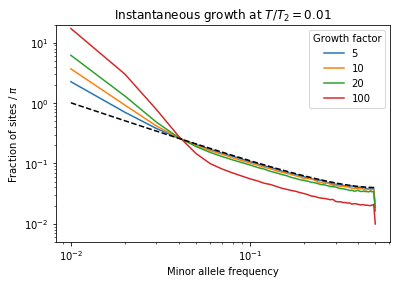

In [42]:
for i in range(4):
    plt.loglog(x, mSFS_pwc[i][0,:]/pi_pwc[i][0], label=int(1.0/s_list[i%4]))
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
plt.xlabel('Minor allele frequency')
plt.ylabel('Fraction of sites / $\pi$')
plt.legend(title=r'Growth factor')
plt.title('Instantaneous growth at $T/T_2 = 0.01$')

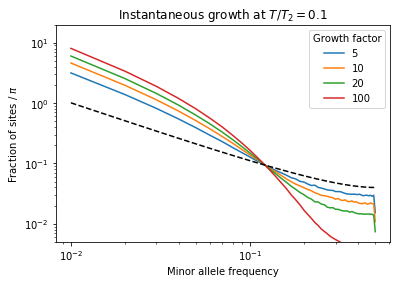

In [43]:
for i in range(4,8):
    plt.loglog(x, mSFS_pwc[i][0,:]/pi_pwc[i][0], label=int(1.0/s_list[i%4]))
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
plt.xlabel('Minor allele frequency')
plt.ylabel('Fraction of sites / $\pi$')
plt.legend(title=r'Growth factor')
plt.title('Instantaneous growth at $T/T_2 = 0.1$')

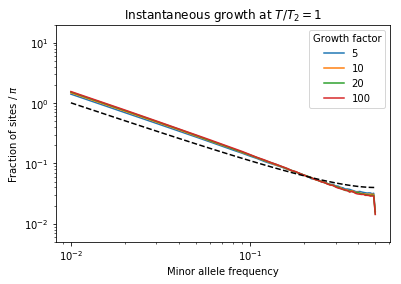

In [44]:
for i in range(8,12):
    plt.loglog(x, mSFS_pwc[i][0,:]/pi_pwc[i][0], label=int(1.0/s_list[i%4]))
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
plt.xlabel('Minor allele frequency')
plt.ylabel('Fraction of sites / $\pi$')
plt.legend(title=r'Growth factor')
plt.title('Instantaneous growth at $T/T_2 = 1$')

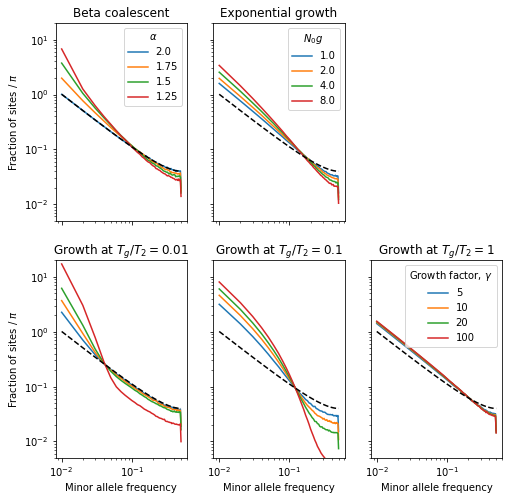

In [45]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(2, 3, 1)
for i,a in enumerate(a_list):
    plt.loglog(x, mSFS_beta[i][0,:]/pi_beta[i][0], label=a)
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
#plt.xlabel('Minor allele frequency')
ax.set_xticklabels([])
plt.ylabel('Fraction of sites / $\pi$')
plt.legend(title=r'$\alpha$')
plt.title('Beta coalescent')

ax = fig.add_subplot(2, 3, 2)
for i,g in enumerate(g_list):
    plt.loglog(x, mSFS_exp[i][0,:]/pi_exp[i][0], label=g)
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
ax.set_yticklabels([])
ax.set_xticklabels([])
#plt.xlabel('Minor allele frequency')
#plt.ylabel('Fraction of sites / $\pi$')
plt.legend(title=r'$N_0g$')
plt.title('Exponential growth')

fig.add_subplot(2, 3, 4)
for i in range(4):
    plt.loglog(x, mSFS_pwc[i][0,:]/pi_pwc[i][0], label=int(1.0/s_list[i%4]))
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
plt.xlabel('Minor allele frequency')
plt.ylabel('Fraction of sites / $\pi$')
#plt.legend(title=r'Growth factor')
plt.title('Growth at $T_g/T_2 = 0.01$')

ax = fig.add_subplot(2, 3, 5)
for i in range(4,8):
    plt.loglog(x, mSFS_pwc[i][0,:]/pi_pwc[i][0], label=int(1.0/s_list[i%4]))
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
plt.xlabel('Minor allele frequency')
#plt.ylabel('Fraction of sites / $\pi$')
#plt.legend(title=r'Growth factor')
ax.set_yticklabels([])
plt.title('Growth at $T_g/T_2 = 0.1$')

ax = fig.add_subplot(2,3,6)
for i in range(8,12):
    plt.loglog(x, mSFS_pwc[i][0,:]/pi_pwc[i][0], label=int(1.0/s_list[i%4]))
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
plt.xlabel('Minor allele frequency')
#plt.ylabel('Fraction of sites / $\pi$')
ax.set_yticklabels([])
plt.legend(title=r'Growth factor, $\gamma$')
plt.title('Growth at $T_g/T_2 = 1$')

plt.savefig('../manuscript/figures/mSFS.pdf')

# 2-site frequency spectra

In [46]:
pmi_max = 1
wpmi_max = 0.005

## Non-recombining loci

Beta coalescent.

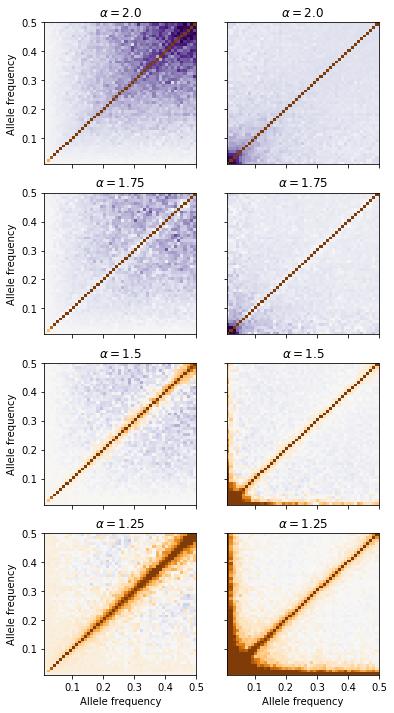

In [47]:
fig = plt.figure(figsize=(6, 12))
for i_a, a in enumerate(a_list):
    ax = fig.add_subplot(4, 2, 2*i_a + 1)
    ax.pcolormesh(x, x, PMI_beta[i_a][0,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr_r')
    ax.set_title(r'$\alpha=${}'.format(a))
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_ylabel('Allele frequency')
    if i_a<3:
        ax.set_xticklabels([])
        #ax.set_yticks([])
    else:
        ax.set_xlabel('Allele frequency')

    
    ax = fig.add_subplot(4, 2, 2*i_a + 2)
    ax.pcolormesh(x, x, wPMI_beta[i_a][0,:,:]/pi_beta[i_a][0]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr_r')
    ax.set_title(r'$\alpha=${}'.format(a))
    ax.set_yticklabels([])
    if i_a<3:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Allele frequency')

plt.savefig('../manuscript/figures/pmi_beta_r0.pdf')
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])

Kingman with exponential growth.

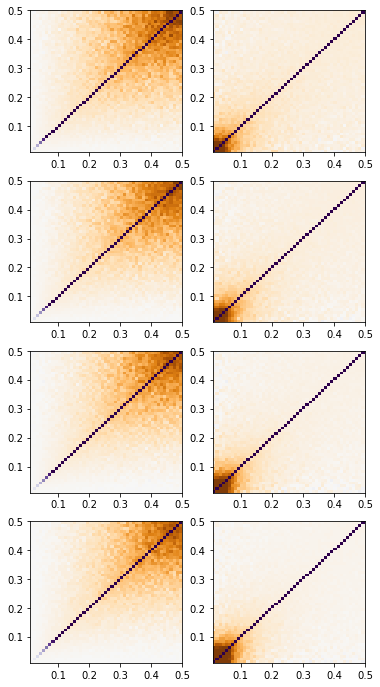

In [48]:
fig = plt.figure(figsize=(6, 12))
for i_g, g in enumerate(g_list):
    ax = fig.add_subplot(4, 2, 2*i_g + 1)
    ax.pcolormesh(x, x, PMI_exp[i_g][0,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    ax = fig.add_subplot(4, 2, 2*i_g + 2)
    ax.pcolormesh(x, x, wPMI_exp[i_g][0,:,:]/pi_exp[i_g][0]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])

Kingman with instantaneous growth.

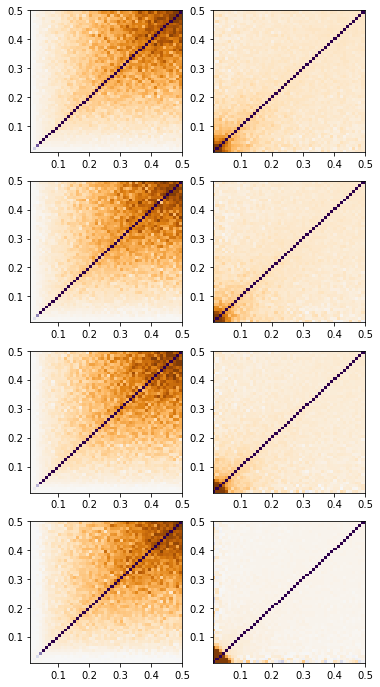

In [49]:
fig = plt.figure(figsize=(6, 12))
for i in range(4):
    ax = fig.add_subplot(4, 2, 2*i + 1)
    ax.pcolormesh(x, x, PMI_pwc[i][0,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    ax = fig.add_subplot(4, 2, 2*i + 2)
    ax.pcolormesh(x, x, wPMI_pwc[i][0,:,:]/pi_pwc[i][0]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])

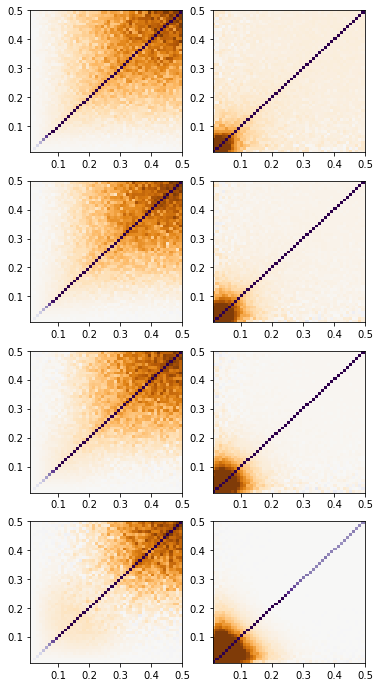

In [50]:
fig = plt.figure(figsize=(6, 12))
for i in range(4,8):
    ax = fig.add_subplot(4, 2, 2*(i%4) + 1)
    ax.pcolormesh(x, x, PMI_pwc[i][0,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    ax = fig.add_subplot(4, 2, 2*(i%4) + 2)
    ax.pcolormesh(x, x, wPMI_pwc[i][0,:,:]/pi_pwc[i][0]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])

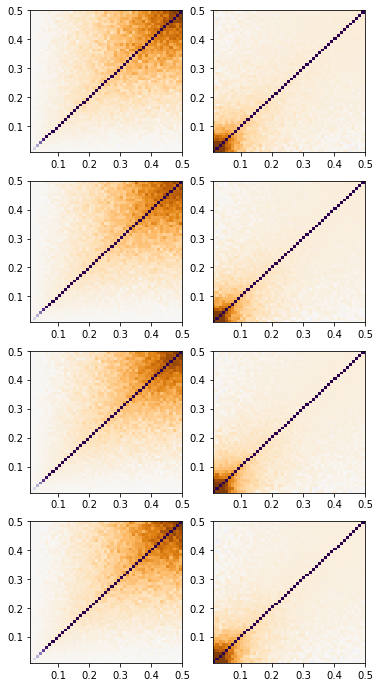

In [51]:
fig = plt.figure(figsize=(6, 12))
for i in range(8,12):
    ax = fig.add_subplot(4, 2, 2*(i%4) + 1)
    ax.pcolormesh(x, x, PMI_pwc[i][0,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    ax = fig.add_subplot(4, 2, 2*(i%4) + 2)
    ax.pcolormesh(x, x, wPMI_pwc[i][0,:,:]/pi_pwc[i][0]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])

Combined figure PMI

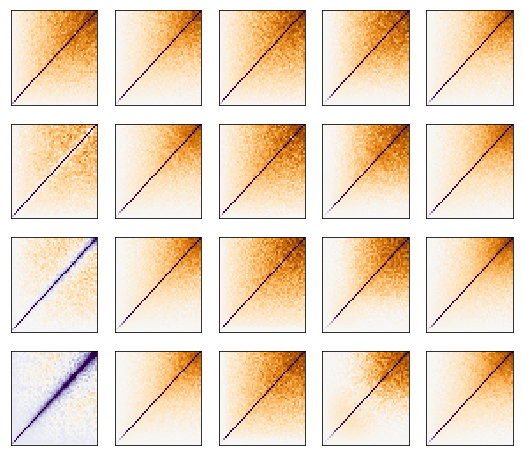

In [52]:
fig = plt.figure(figsize=(9, 8))

# Beta coalescent
for i in range(4):
    ax = fig.add_subplot(4, 5, 5*i + 1)
    ax.pcolormesh(x, x, PMI_beta[i][0,:,:],
        vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.title('$\alpha={}$'.format(a_list[i]))

# Exponential growth
for i in range(4):
    ax = fig.add_subplot(4, 5, 5*i + 2)
    ax.pcolormesh(x, x, PMI_exp[i][0,:,:],
        vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')
    ax.set_xticks([])
    ax.set_yticks([])

# Step growth
for i in range(12):
    ax = fig.add_subplot(4, 5, 5*(i%4) + 3 + i//4)
    ax.pcolormesh(x, x, PMI_pwc[i][0,:,:],
        vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')
    ax.set_xticks([])
    ax.set_yticks([])

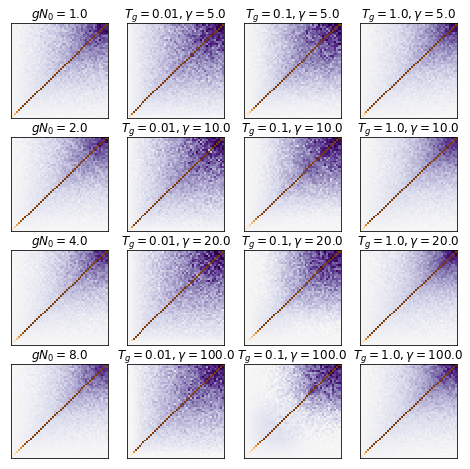

In [53]:
fig = plt.figure(figsize=(8, 8))

# Exponential growth
for i in range(4):
    ax = fig.add_subplot(4, 4, 4*i + 1)
    ax.pcolormesh(x, x, PMI_exp[i][0,:,:],
        vmin=-pmi_max, vmax=pmi_max, cmap='PuOr_r')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('$gN_0={}$'.format(g_list[i]))

# Step growth
for i in range(12):
    ax = fig.add_subplot(4, 4, 4*(i%4) + 2 + i//4)
    ax.pcolormesh(x, x, PMI_pwc[i][0,:,:],
        vmin=-pmi_max, vmax=pmi_max, cmap='PuOr_r')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('$T_g={}, \gamma={}$'.format(t_list[i//4], 1/s_list[i%4]))

plt.savefig('../manuscript/figures/pmi_growth_r0.pdf')

Combined figure wPMI

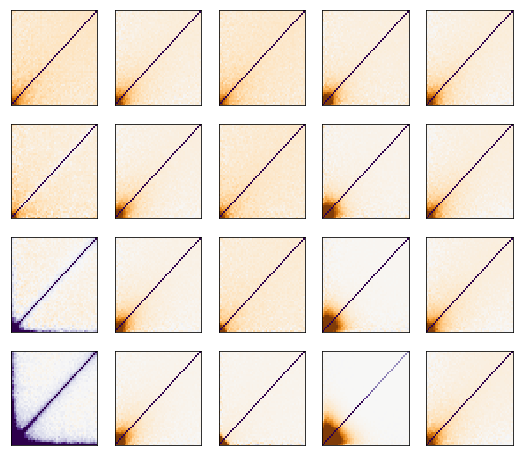

In [54]:
fig = plt.figure(figsize=(9, 8))

# Beta coalescent
for i in range(4):
    ax = fig.add_subplot(4, 5, 5*i + 1)
    ax.pcolormesh(x, x, wPMI_beta[i][0,:,:]/pi_beta[i][0]**2,
        vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.title('$\alpha={}$'.format(a_list[i]))

# Exponential growth
for i in range(4):
    ax = fig.add_subplot(4, 5, 5*i + 2)
    ax.pcolormesh(x, x, wPMI_exp[i][0,:,:]/pi_exp[i][0]**2,
        vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')
    ax.set_xticks([])
    ax.set_yticks([])

# Step growth
for i in range(12):
    ax = fig.add_subplot(4, 5, 5*(i%4) + 3 + i//4)
    ax.pcolormesh(x, x, wPMI_pwc[i][0,:,:]/pi_pwc[i][0]**2,
        vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')
    ax.set_xticks([])
    ax.set_yticks([])


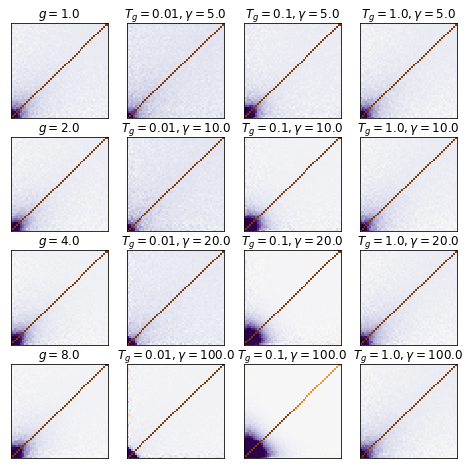

In [55]:
fig = plt.figure(figsize=(8, 8))

# Exponential growth
for i in range(4):
    ax = fig.add_subplot(4, 4, 4*i + 1)
    ax.pcolormesh(x, x, wPMI_exp[i][0,:,:]/pi_exp[i][0]**2,
        vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr_r')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('$g={}$'.format(g_list[i]))

# Step growth
for i in range(12):
    ax = fig.add_subplot(4, 4, 4*(i%4) + 2 + i//4)
    ax.pcolormesh(x, x, wPMI_pwc[i][0,:,:]/pi_pwc[i][0]**2,
        vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr_r')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('$T_g={}, \gamma={}$'.format(t_list[i//4], 1/s_list[i%4]))

plt.savefig('../manuscript/figures/wpmi_growth_r0.pdf')

## Recombining loci

Beta coalescent PMI and wPMI.

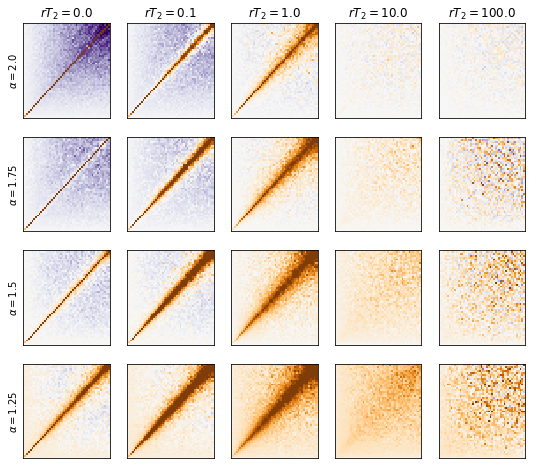

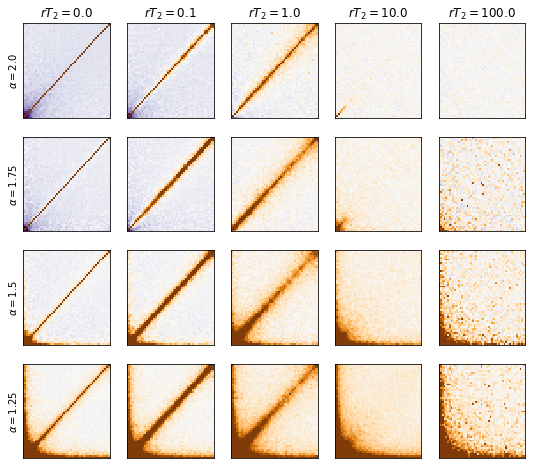

In [56]:
fig1 = plt.figure(figsize=(9, 8))
fig2 = plt.figure(figsize=(9, 8))

# Beta coalescent
for i in range(4):
    for col, r in enumerate([0, 0.1, 1.0, 10.0, 100.0]):
        i_r = list(r_list).index(r)
        ax = fig1.add_subplot(4, 5, 5*i + col + 1)
        ax.pcolormesh(x, x, PMI_beta[i][i_r,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr_r')
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            ax.set_ylabel(r'$\alpha={}$'.format(a_list[i]))
        if i == 0:
            ax.set_title(r'$rT_2={}$'.format(r_list[i_r]))
        
        ax = fig2.add_subplot(4, 5, 5*i + col + 1)
        ax.pcolormesh(x, x, wPMI_beta[i][i_r,:,:]/pi_beta[i][i_r]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr_r')
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            ax.set_ylabel(r'$\alpha={}$'.format(a_list[i]))
        if i == 0:
            ax.set_title(r'$rT_2={}$'.format(r_list[i_r]))
fig2.savefig('../manuscript/figures/wpmi_beta_r.pdf')

Difference between beta PMI and Kingman PMI unweighted, then weighted.

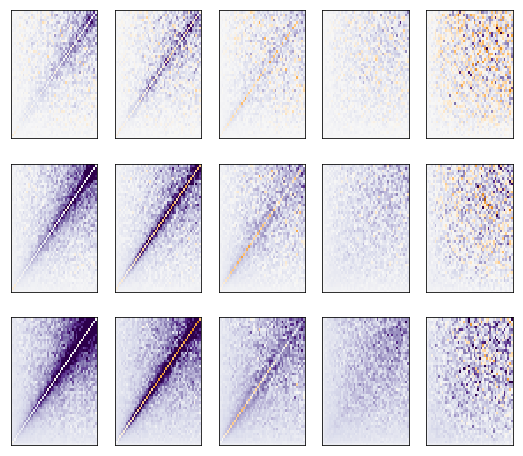

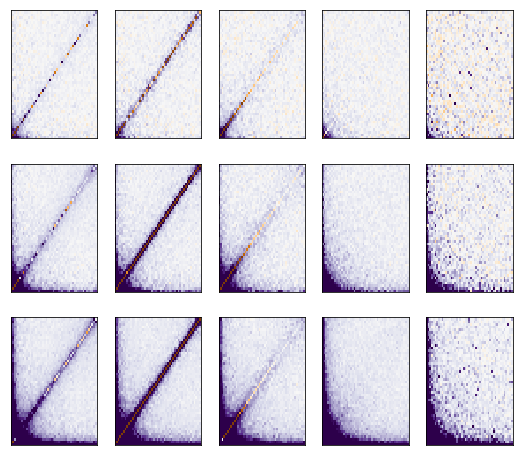

In [57]:
fig1 = plt.figure(figsize=(9, 8))
fig2 = plt.figure(figsize=(9, 8))

# Beta coalescent
for i in range(1,4):
    for col, r in enumerate([0, 0.1, 1.0, 10.0, 100.0]):
        i_r = list(r_list).index(r)
        ax = fig1.add_subplot(3, 5, 5*(i-1) + col + 1)
        ax.pcolormesh(x, x, PMI_beta[i][i_r,:,:] - PMI_beta[0][i_r,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax = fig2.add_subplot(3, 5, 5*(i-1) + col + 1)
        ax.pcolormesh(x, x, (PMI_beta[i][i_r,:,:] - PMI_beta[0][i_r,:,:])*
                                jSFS_beta[i][i_r,:,:]/pi_beta[i][i_r]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')
        ax.set_xticks([])
        ax.set_yticks([])

Exponential growth. Grid by $rho$.

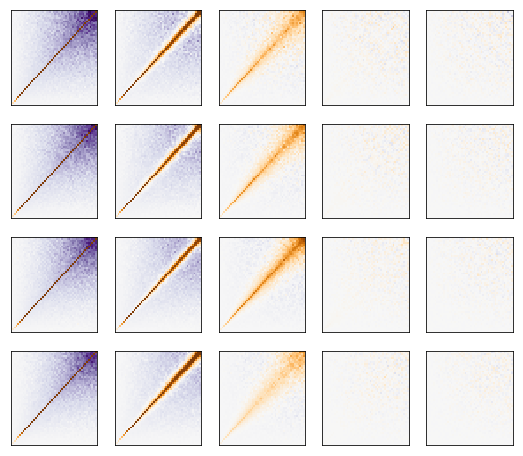

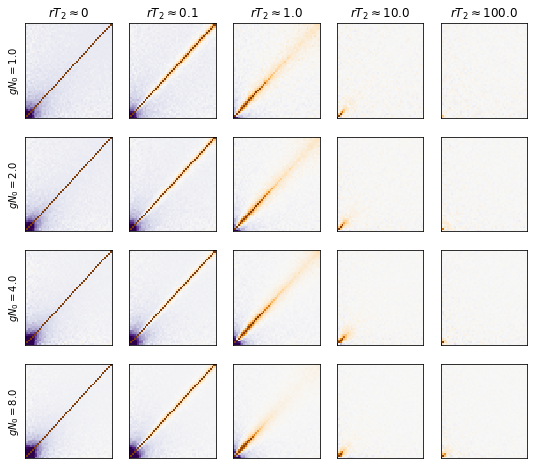

In [58]:
fig1 = plt.figure(figsize=(9, 8))
fig2 = plt.figure(figsize=(9, 8))
for i in range(4):
    for col, r in enumerate([0, 0.1, 1.0, 10.0, 100.0]):
        rho = r_list[:-3]*pi_exp[i]/2
        i_r = np.argmin(np.abs(rho-r))
        #print(r, rho[i_r])

        #i_r = list(r_list).index(r)
        ax = fig1.add_subplot(4, 5, 5*i + col + 1)
        ax.pcolormesh(x, x, PMI_exp[i][i_r,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr_r')
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax = fig2.add_subplot(4, 5, 5*i + col + 1)
        ax.pcolormesh(x, x, wPMI_exp[i][i_r,:,:]/pi_exp[i][i_r]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr_r')
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            ax.set_ylabel(r'$gN_0={}$'.format(g_list[i]))
        if i == 0:
            ax.set_title(r'$rT_2 \approx {}$'.format(r))
fig2.savefig('../manuscript/figures/wpmi_exp_r.pdf')

Instantaneous growth. Grid by $\rho$ rather than $r$.

0 0.0
0.1 0.0964410932336
1.0 0.962352569812
10.0 9.64572091535
100.0 96.562529292
0 0.0
0.1 0.108966072233
1.0 1.08893650335
10.0 10.9077860228
100.0 108.824732871
0 0.0
0.1 0.128000971533
1.0 1.28175681244
10.0 12.8142824983
100.0 59.4722427222
0 0.0
0.1 0.0920612319954
1.0 0.920610159812
10.0 9.21092473343
100.0 19.8653531649
0 0.0
0.1 0.12817306823
1.0 1.28179882673
10.0 12.8202175019
100.0 128.101212396
0 0.0
0.1 0.0861479487511
1.0 0.862833937775
10.0 8.61738150953
100.0 86.1566245183
0 0.0
0.1 0.0651679195899
1.0 0.652024834916
10.0 6.51346811869
100.0 65.2207292204
0 0.0
0.1 0.104217522744
1.0 1.04188110793
10.0 10.4189976811
100.0 104.207946747
0 0.0
0.1 0.0705932704157
1.0 0.705735548858
10.0 7.05639022379
100.0 70.5453748624
0 0.0
0.1 0.066863057989
1.0 0.66867757559
10.0 6.6899178123
100.0 66.8861608052
0 0.0
0.1 0.0650916518166
1.0 0.650583725751
10.0 6.50506638262
100.0 65.0644532727
0 0.0
0.1 0.0634546826556
1.0 0.635842323143
10.0 6.35740841932
100.0 63.5601173928


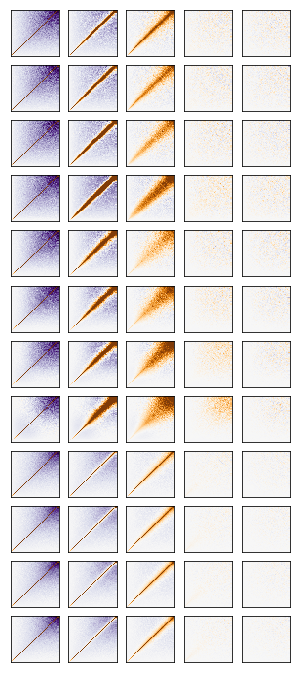

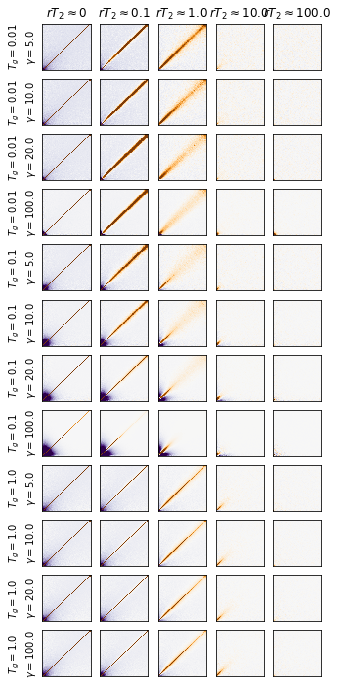

In [59]:
fig1 = plt.figure(figsize=(5, 12))
fig2 = plt.figure(figsize=(5, 12))

n_row = 12
n_col = 5
for i in range(12):
    for col, r in enumerate([0, 0.1, 1.0, 10.0, 100.0]):
        rho = r_list*pi_pwc[i]/2
        i_r = np.argmin(np.abs(rho-r))
        print(r, rho[i_r])

        #i_r = col
        ax = fig1.add_subplot(12, n_col, n_col*i + col + 1)
        ax.pcolormesh(x, x, PMI_pwc[i][i_r,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr_r')
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax = fig2.add_subplot(12, n_col, n_col*i + col + 1)
        ax.pcolormesh(x, x, wPMI_pwc[i][i_r,:,:]/pi_pwc[i][i_r]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr_r')
        ax.set_xticks([])
        ax.set_yticks([])
        
        if col == 0:
            ax.set_ylabel('$T_g={}$\n$\gamma={}$'.format(t_list[i//4], 1/s_list[i%4]))
        if i == 0:
            ax.set_title(r'$rT_2 \approx {}$'.format(r))
fig2.savefig('../manuscript/figures/wpmi_step_r.pdf')

# Reduced-SFS correlations

In [61]:
def reduce_sfs(SFS, jSFS, cutoff=1):
    n_rows = SFS.shape[0]
    
    r_SFS = np.zeros((n_rows,2))
    r_SFS[:,0] = np.sum(SFS[:,:cutoff], axis=1)
    r_SFS[:,1] = np.sum(SFS[:,cutoff:], axis=1)
    
    r_jSFS = np.zeros((n_rows,2,2))
    r_jSFS[:,0,0] = np.sum(jSFS[:, :cutoff, :cutoff], axis=(1,2))
    r_jSFS[:,0,1] = np.sum(jSFS[:, :cutoff, cutoff:], axis=(1,2))
    r_jSFS[:,1,0] = np.sum(jSFS[:, cutoff:, :cutoff], axis=(1,2))
    r_jSFS[:,1,1] = np.sum(jSFS[:, cutoff:, cutoff:], axis=(1,2))

    r_PMI = pmi(r_SFS, r_jSFS)
    return r_SFS, r_jSFS, r_PMI

1


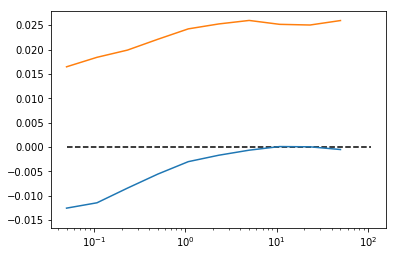

2


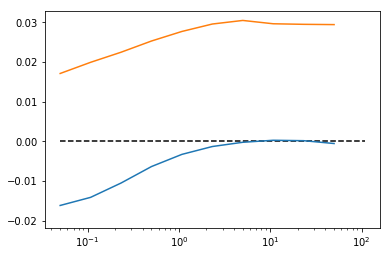

3


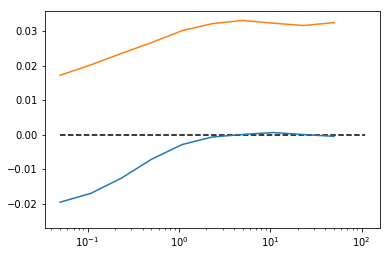

4


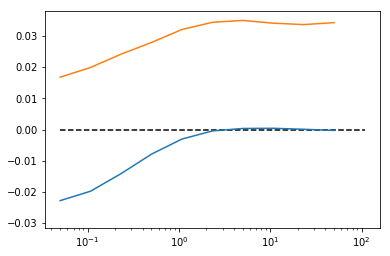

5


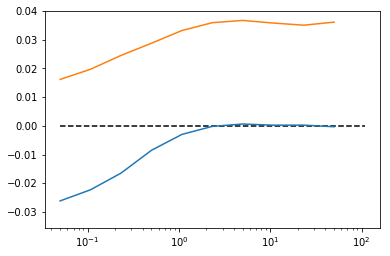

6


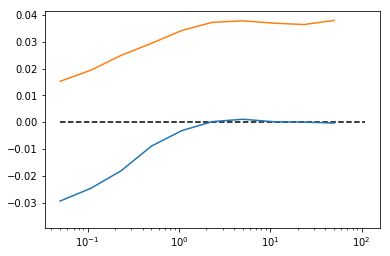

7


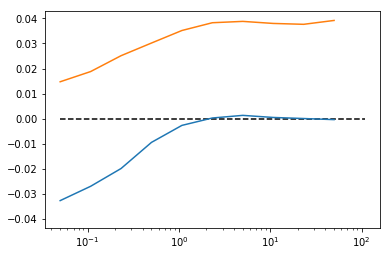

8


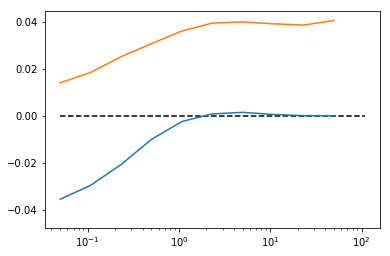

9


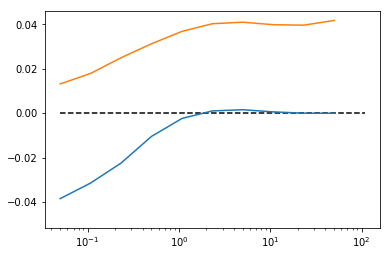

10


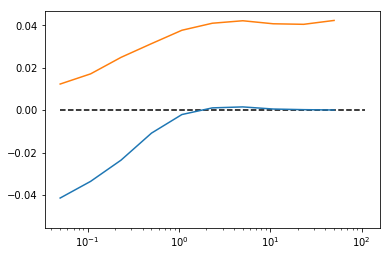

11


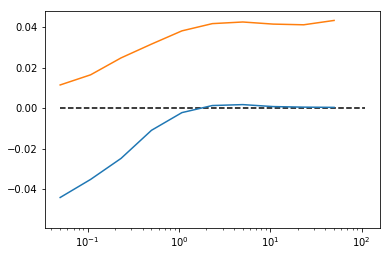

12


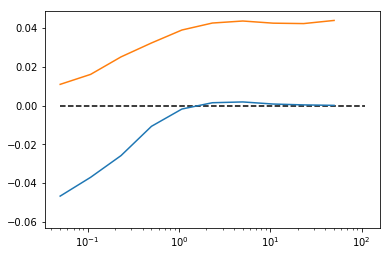

13


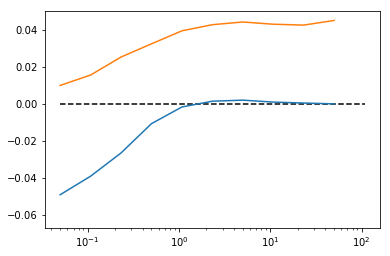

14


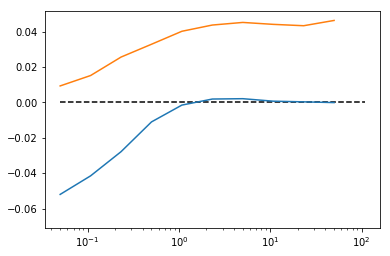

15


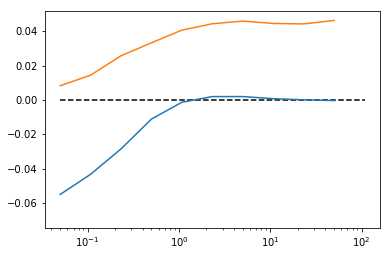

16


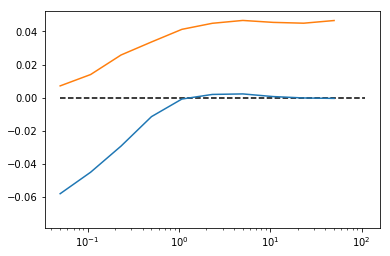

17


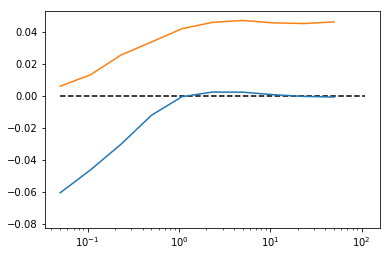

18


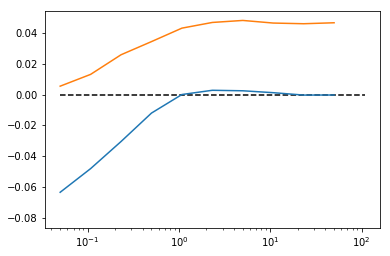

19


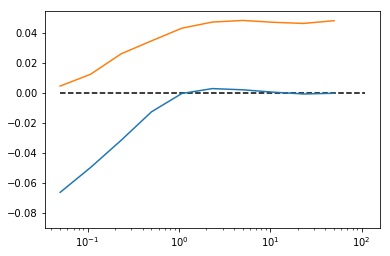

20


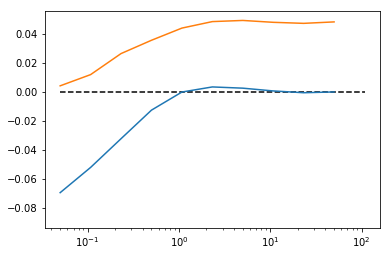

21


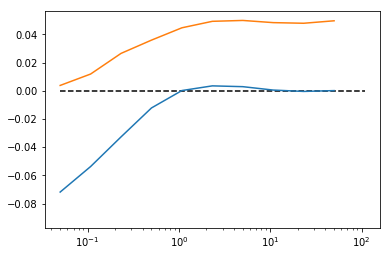

22


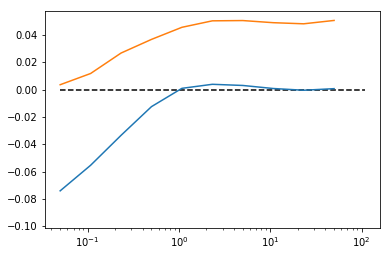

23


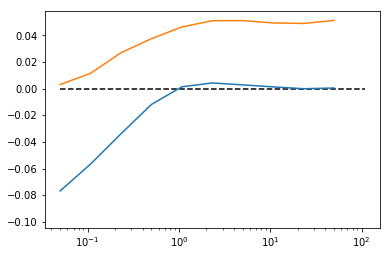

24


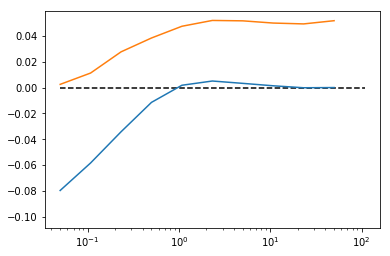

25


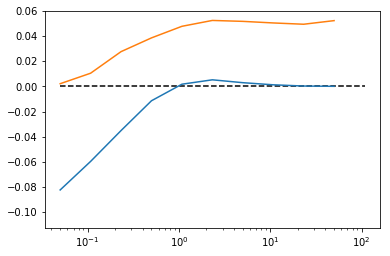

26


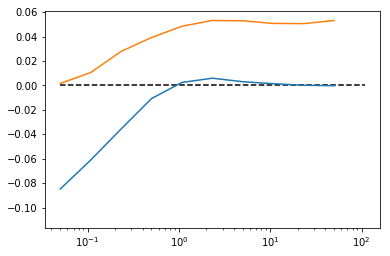

27


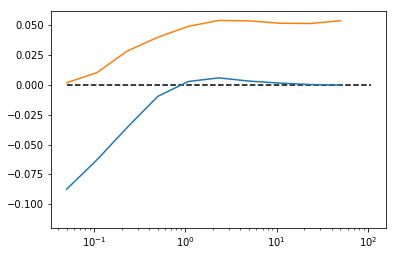

28


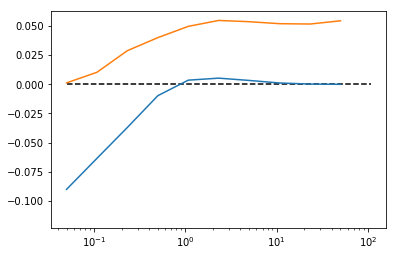

29


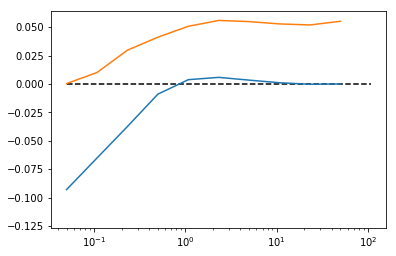

30


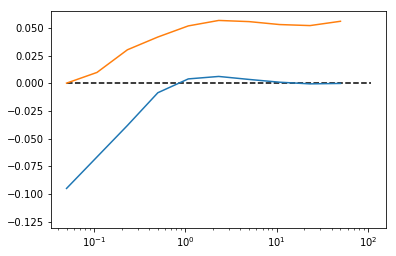

31


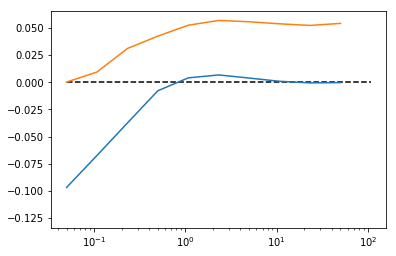

32


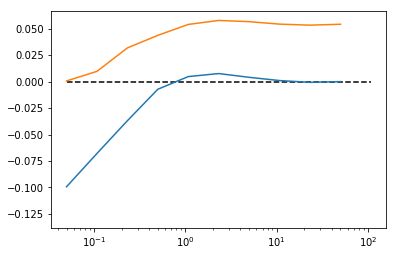

33


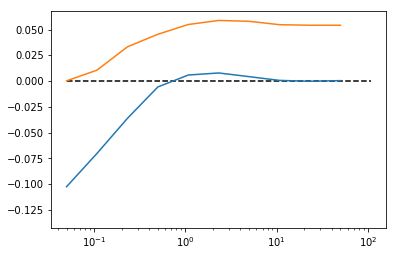

34


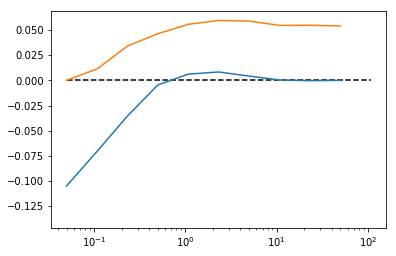

35


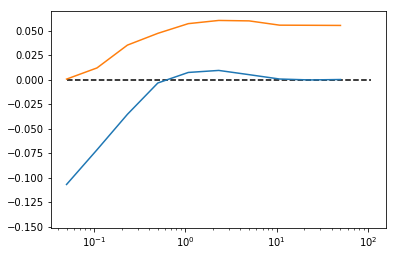

36


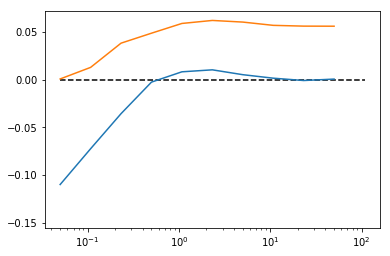

37


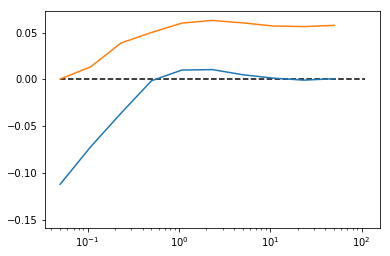

38


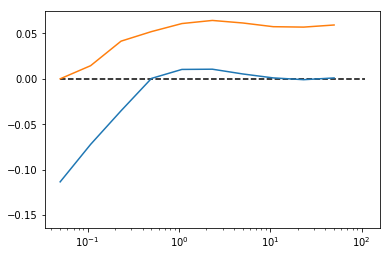

39


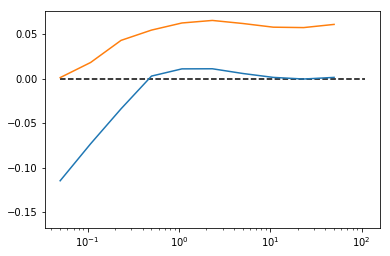

40


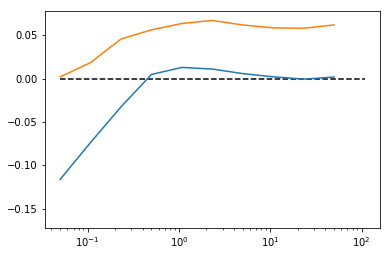

41


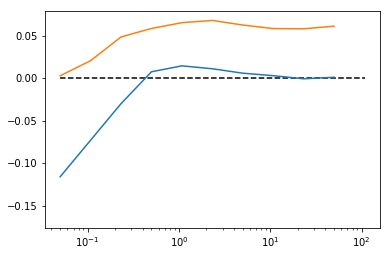

42


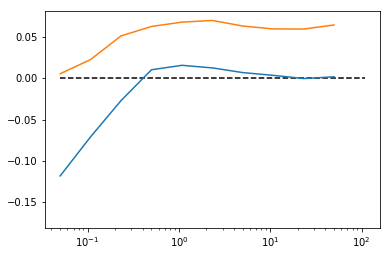

43


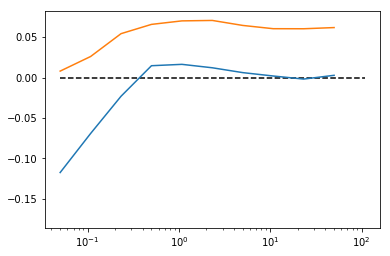

44


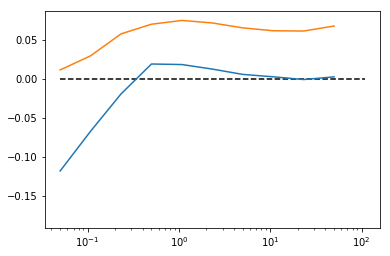

45


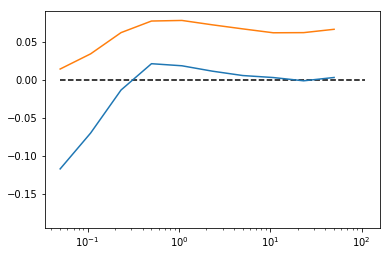

46


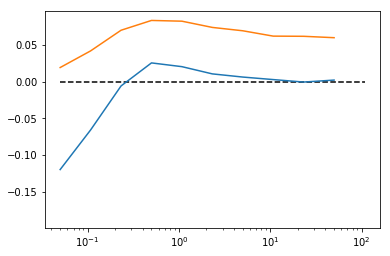

47


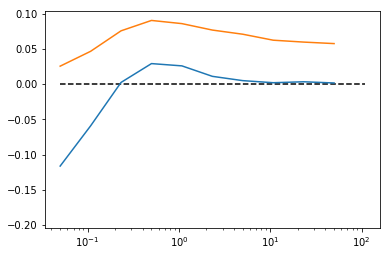

48


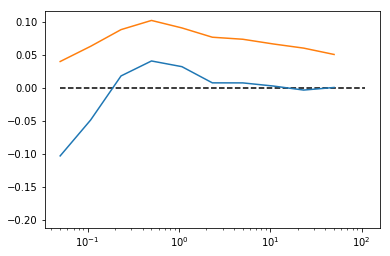

In [62]:
for cutoff in range(1, 49):
    rmSFS_k, rjSFS_k, rPMI_k = reduce_sfs(mSFS_beta[0], jSFS_beta[0], cutoff)
    rmSFS_b, rjSFS_b, rPMI_b = reduce_sfs(mSFS_beta[2], jSFS_beta[2], cutoff)
    plt.semilogx(r_list[:-3]/2, rPMI_k[:,0,1])
    plt.semilogx(r_list[:-3]/2, rPMI_b[:,0,1])
    plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed')
    print(cutoff)
    plt.show()

## Application

In [88]:
cutoff = 40
rPMI_beta = [reduce_sfs(mSFS_beta[i], jSFS_beta[i], cutoff)[2] for i in range(len(a_list))]
rPMI_exp = [reduce_sfs(mSFS_exp[i], jSFS_exp[i], cutoff)[2] for i in range(len(g_list))]
rPMI_pwc = [reduce_sfs(mSFS_pwc[i], jSFS_pwc[i], cutoff)[2] for i in range(len(s_list)*len(t_list))]

/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


### Beta coalescent

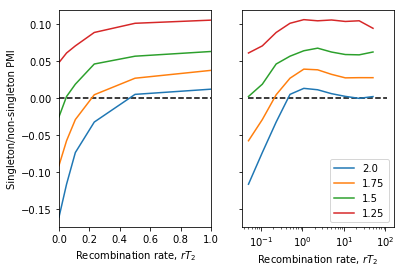

In [89]:
fig = plt.figure()

ax = fig.add_subplot(121)
for rPMI in rPMI_beta:
    plt.plot(r_list[:-3]/2, rPMI[:,0,1])
plt.hlines(0,0,1, linestyle='dashed')
plt.xlim([0,1])
ax.set_xlabel('Recombination rate, $rT_2$')
ax.set_ylabel('Singleton/non-singleton PMI')

ax = fig.add_subplot(122)
for i, rPMI in enumerate(rPMI_beta):
    plt.semilogx(r_list[:-3]/2, rPMI[:,0,1], label=a_list[i])
plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed')
ax.set_yticklabels([])
ax.set_xlabel('Recombination rate, $rT_2$')
ax.legend()

#fig.savefig('../manuscript/figures/singleton_pmi_beta.pdf')

### Exponential growth

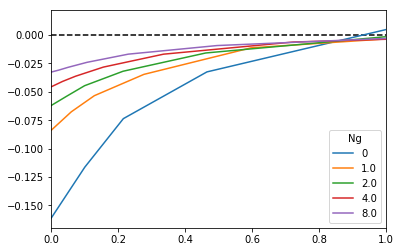

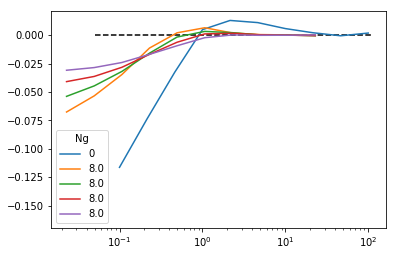

In [90]:
plt.plot(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for i, rPMI in enumerate(rPMI_exp):
    plt.plot(r_list[:-3]*pi_exp[i]/2, rPMI[:,0,1], label=g_list[i])
plt.hlines(0,0,1, linestyle='dashed')
plt.xlim([0,1])
plt.legend(title='Ng')
plt.show()

plt.semilogx(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for rPMI in rPMI_exp:
    plt.semilogx(r_list[:-3]*pi_exp[i]/2, rPMI[:,0,1], label=g_list[i])
plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed')
plt.legend(title='Ng')

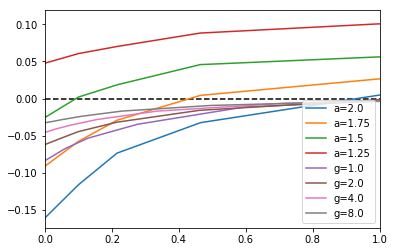

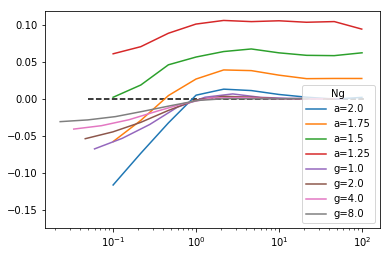

In [91]:
for i, rPMI in enumerate(rPMI_beta):
    plt.plot(r_list[:-3]*pi_beta[i]/2, rPMI[:,0,1], label='a={}'.format(a_list[i]))
for i, rPMI in enumerate(rPMI_exp):
    plt.plot(r_list[:-3]*pi_exp[i]/2, rPMI[:,0,1], label='g={}'.format(g_list[i]))
plt.hlines(0,0,1, linestyle='dashed')
plt.xlim([0,1])
plt.legend()
plt.show()

for i, rPMI in enumerate(rPMI_beta):
    plt.semilogx(r_list[:-3]*pi_beta[i]/2, rPMI[:,0,1], label='a={}'.format(a_list[i]))
for i, rPMI in enumerate(rPMI_exp):
    plt.semilogx(r_list[:-3]*pi_exp[i]/2, rPMI[:,0,1], label='g={}'.format(g_list[i]))
plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed')
plt.legend(title='Ng')

### Instantaneous growth

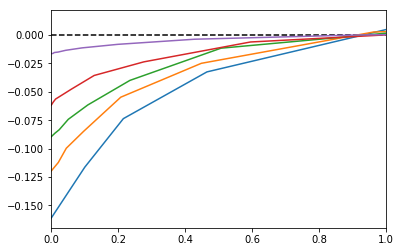

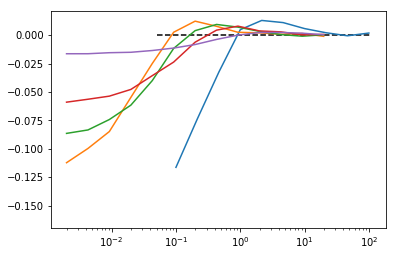

In [92]:
plt.plot(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for i, rPMI in enumerate(rPMI_pwc[:4]):
    plt.plot(r_list*pi_pwc[i]/2, rPMI[:,0,1])#, label=g_list[i])
plt.hlines(0,0,1, linestyle='dashed')
plt.xlim([0,1])
#plt.legend(title='Ng')
plt.show()

plt.semilogx(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for rPMI in rPMI_pwc[:4]:
    plt.semilogx(r_list*pi_pwc[i]/2, rPMI[:,0,1])#, label=g_list[i])
plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed')
#plt.legend(title='Ng')

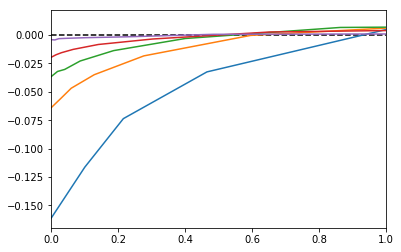

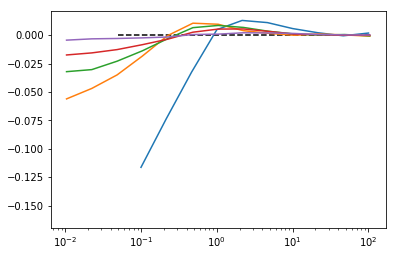

In [188]:
plt.plot(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for i, rPMI in enumerate(rPMI_pwc[4:8]):
    plt.plot(r_list*pi_pwc[i+4]/2, rPMI[:,0,1])#, label=g_list[i])
plt.hlines(0,0,1, linestyle='dashed')
plt.xlim([0,1])
#plt.legend(title='Ng')
plt.show()

plt.semilogx(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for rPMI in rPMI_pwc[4:8]:
    plt.semilogx(r_list*pi_pwc[i+4]/2, rPMI[:,0,1])#, label=g_list[i])
plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed')
#plt.legend(title='Ng')

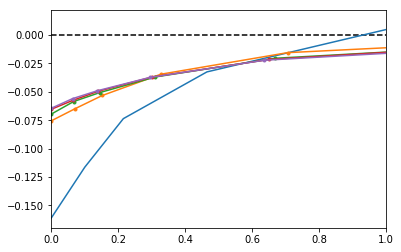

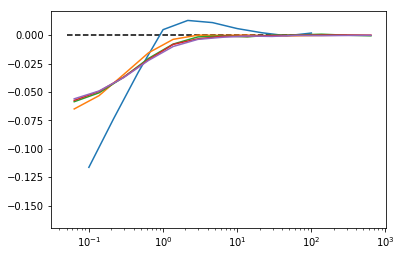

In [189]:
plt.plot(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for i, rPMI in enumerate(rPMI_pwc[8:]):
    plt.plot(r_list*pi_pwc[i+8]/2, rPMI[:,0,1], '.-')#, label=g_list[i])
plt.hlines(0,0,1, linestyle='dashed')
plt.xlim([0,1])
#plt.legend(title='Ng')
plt.show()

plt.semilogx(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for rPMI in rPMI_pwc[8:]:
    plt.semilogx(r_list*pi_pwc[i+8]/2, rPMI[:,0,1])#, label=g_list[i])
plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed')
#plt.legend(title='Ng')

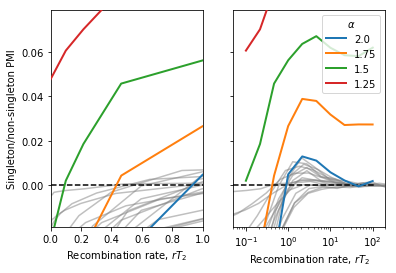

In [95]:
fig = plt.figure()

ax = fig.add_subplot(121)
for i, rPMI in enumerate(rPMI_beta):
    plt.plot(r_list[:-3]*pi_beta[i]/2, rPMI[:,0,1], label=a_list[i], zorder=3, lw=2)
for i, rPMI in enumerate(rPMI_exp):
    plt.plot(r_list[:-3]*pi_exp[i]/2, rPMI[:,0,1], color='.5', alpha=.5)
for i, rPMI in enumerate(rPMI_pwc):
    plt.plot(r_list*pi_pwc[i]/2, rPMI[:,0,1], color='.5', alpha=.5)

plt.hlines(0,0,1, linestyle='dashed', zorder=3)
plt.xlim([0,1])
ax.set_ylim([-0.019,0.079])
ax.set_xlabel('Recombination rate, $rT_2$')
ax.set_ylabel('Singleton/non-singleton PMI')

ax = fig.add_subplot(122)
for i, rPMI in enumerate(rPMI_beta):
    plt.semilogx(r_list[:-3]*pi_beta[i]/2, rPMI[:,0,1], label=a_list[i], zorder=3, lw=2)
for i, rPMI in enumerate(rPMI_exp):
    plt.semilogx(r_list[:-3]*pi_exp[i]/2, rPMI[:,0,1], color='.5', alpha=.5)
for i, rPMI in enumerate(rPMI_pwc):
    plt.semilogx(r_list*pi_pwc[i]/2, rPMI[:,0,1], color='.5', alpha=.5)
plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed', zorder=3)
ax.set_xlim([.05,200])
ax.set_ylim([-0.019,0.079])
ax.set_yticklabels([])
ax.set_xlabel('Recombination rate, $rT_2$')
ax.legend(title=r'$\alpha$')
#fig.savefig('../manuscript/figures/singleton_pmi_all.pdf')

# PI correlation

In [145]:
def jsfs2picorr(jsfs):
    weights = h.pairwise_diversity(np.arange(1, n_samples//2 + 1), n_samples)
    return np.sum(jsfs * weights[None, :, None]*weights[None, None, :], axis=(1,2))

0.907994227795
0.951697604536
1.05404930626
1.178152464


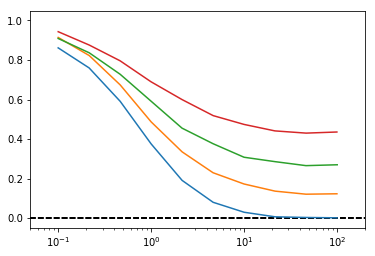

In [180]:
for pi, jsfs in zip(pi_beta, jSFS_beta):
    pi_corr = jsfs2picorr(jsfs) - pi**2
    plt.semilogx(r_list[:-3]*pi/2, pi_corr/pi_corr[0])
    plt.xlim([5e-2,2e2])
    plt.hlines(0, 5e-2, 2e2, linestyle='dashed')
    print(pi_corr[0])

0.109252143471
0.0443819642545
0.0155002878803
0.00476493725135


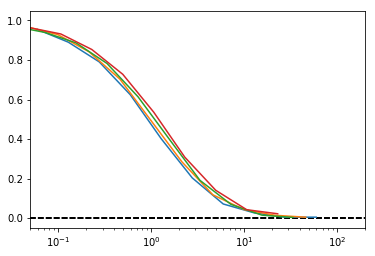

In [179]:
for pi, jsfs in zip(pi_exp, jSFS_exp):
    pi_corr = jsfs2picorr(jsfs) - pi**2
    plt.semilogx(r_list[:-3]*pi/2, pi_corr/pi_corr[0])
    plt.xlim([5e-2,2e2])
    plt.hlines(0, 5e-2, 2e2, linestyle='dashed')
    print(pi_corr[0])

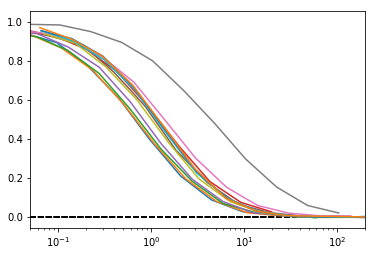

In [178]:
for pi, jsfs in zip(pi_pwc, jSFS_pwc):
    pi_corr = jsfs2picorr(jsfs) - pi**2
    plt.semilogx(r_list[:len(pi_corr)]*pi/2, pi_corr/pi_corr[0])
    plt.xlim([5e-2,2e2])
    plt.hlines(0, 5e-2, 2e2, linestyle='dashed')

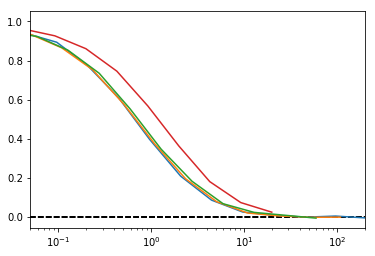

In [181]:
for pi, jsfs in zip(pi_pwc[:4], jSFS_pwc[:4]):
    pi_corr = jsfs2picorr(jsfs) - pi**2
    plt.semilogx(r_list[:len(pi_corr)]*pi/2, pi_corr/pi_corr[0])
    plt.xlim([5e-2,2e2])
    plt.hlines(0, 5e-2, 2e2, linestyle='dashed')

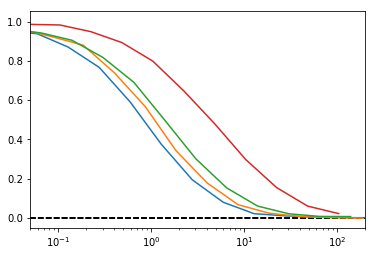

In [182]:
for pi, jsfs in zip(pi_pwc[4:8], jSFS_pwc[4:8]):
    pi_corr = jsfs2picorr(jsfs) - pi**2
    plt.semilogx(r_list[:len(pi_corr)]*pi/2, pi_corr/pi_corr[0])
    plt.xlim([5e-2,2e2])
    plt.hlines(0, 5e-2, 2e2, linestyle='dashed')

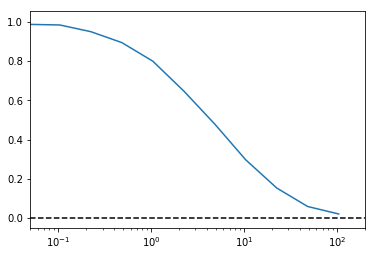

In [186]:
for pi, jsfs in zip([pi_pwc[7]], [jSFS_pwc[7]]):
    pi_corr = jsfs2picorr(jsfs) - pi**2
    plt.semilogx(r_list[:len(pi_corr)]*pi/2, pi_corr/pi_corr[0])
    plt.xlim([5e-2,2e2])
    plt.hlines(0, 5e-2, 2e2, linestyle='dashed')

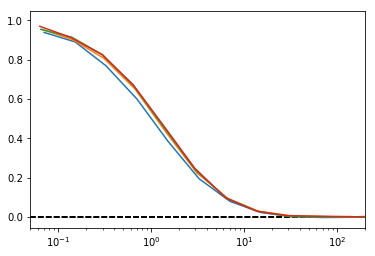

In [183]:
for pi, jsfs in zip(pi_pwc[8:], jSFS_pwc[8:]):
    pi_corr = jsfs2picorr(jsfs) - pi**2
    plt.semilogx(r_list[:len(pi_corr)]*pi/2, pi_corr/pi_corr[0])
    plt.xlim([5e-2,2e2])
    plt.hlines(0, 5e-2, 2e2, linestyle='dashed')

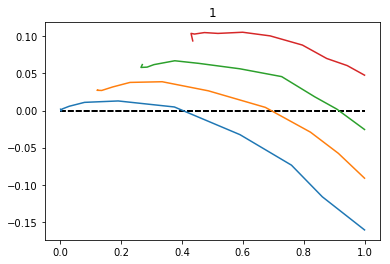

In [194]:
#for cutoff_freq in range(1,50):
cutoff_freq = 1
rPMI_beta = [reduce_sfs(mSFS_beta[i], jSFS_beta[i], cutoff)[2] for i in range(len(a_list))]

for pi, jsfs, rPMI in zip(pi_beta, jSFS_beta, rPMI_beta):
    pi_corr = jsfs2picorr(jsfs) - pi**2
    plt.plot(pi_corr/pi_corr[0], rPMI[:,0,1], '-')
    plt.hlines(0,0,1,linestyle='dashed')
    plt.title(cutoff_freq)
plt.show()